<a href="https://colab.research.google.com/github/arkham1994/Assignments_Precily/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing all the required libraries

import os
import cv2
import random
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
from keras.models import Model, load_model
from skimage.transform import resize

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label
from shutil import copyfile
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import save_img

np.random.seed = 42





In [29]:
# Connecting with Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Making Colab Notebooks as current directory

%cd /content/drive/My Drive/Colab Notebooks   

/content/drive/My Drive/Colab Notebooks


In [4]:
# Unzipping the zip file into my directory

!unzip CelebAMask-HQ.zip

In [5]:
# Making new Folder to store all the combined mask of eyes and lips for each unique image

os.mkdir('Img_Masks')

In [34]:
# Checking if the path exists

os.path.exists('/content/drive/My Drive/Colab Notebooks/Img_Masks')

True

In [14]:
# Here I have generated combined eyes and lips masks for each unique image(only first 2000)


for i in range(0,2000):
        if i <10:
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/0000'
        elif i<100:
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/000'
        elif i <1000: 
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00'
        elif i<10000:
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/0'
        else: 
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'    
            
        if os.path.isfile(path + '{}_l_lip.png'.format(i)) and os.path.isfile(path + '{}_u_lip.png'.format(i)) and os.path.isfile(path + '{}_l_eye.png'.format(i)) and os.path.isfile(path + '{}_r_eye.png'.format(i)):
            im1=imread(path + '{}_l_lip.png'.format(i))
            im2=imread(path + '{}_u_lip.png'.format(i))
            im3=imread(path + '{}_l_eye.png'.format(i)) 
            im4=imread(path + '{}_r_eye.png'.format(i))
            im5=np.maximum(np.asarray(im1),np.asarray(im2))
            im6=np.maximum(np.asarray(im3),np.asarray(im4))
            im7=np.maximum(np.asarray(im5),np.asarray(im6))
        
        save_path = '/content/drive/My Drive/Colab Notebooks/Img_Masks/'
        save_img(save_path + 'mask{}.png'.format(i), im7)

        

In [16]:
# Width and Height are decided based on the image as well as the computational power it requires

img_width = 128
img_height = 128
img_channel = 3

In [17]:
# Generating empty arrays for training and testing data
# Taking first 1800 images as training data
# Taking remaining 200 images as testing data

X_train = np.zeros((1800, img_height, img_width, img_channel), dtype=np.uint8)   
Y_train = np.zeros((1800, img_height, img_width, 1), dtype= bool)
X_test = np.zeros((200, img_height, img_width, img_channel), dtype=np.uint8)

In [18]:
# Bulding the model for Eyes and Lips Segmentation based on U-Net architecture


inputs = tf.keras.layers.Input((img_width, img_height, img_channel))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

# Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
 
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
# Model Checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_img_segmentation.h5', verbose = 1, save_best_only = True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir = 'logs')]




In [ ]:
# Loading first 1800 Training images data into X_train array

folder = '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebA-HQ-img/'

def load_images_from_folder(folder):
    images = []
    for i in range(0,1800):
        img = imread(os.path.join(folder,'{}.jpg'.format(i)))[:,:,:img_channel]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_train[i] = img
        
    return None 

load_images_from_folder(folder)

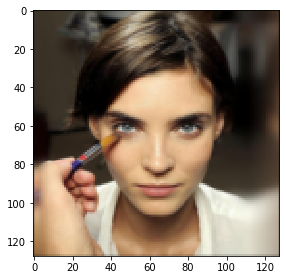

In [74]:
imshow(X_train[29])
plt.show()

In [ ]:
# Loading next 200 Training images data into X_test array

folder = '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebA-HQ-img/'
def load_images_from_folder(folder):
    images = []
    for i in range(1800,2000):
        img = imread(os.path.join(folder,'{}.jpg'.format(i)))[:,:,:img_channel]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_test[i - 1800] = img
        
    return None 

load_images_from_folder(folder)

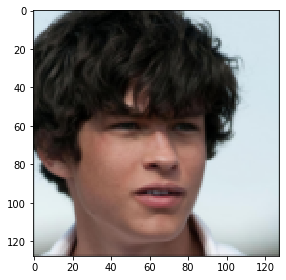

In [75]:
imshow(X_test[199])
plt.show()

In [ ]:
# Loading first 1800 mask images data into Y_train array

for i in range(0,1800):
    mask = np.zeros((img_height, img_width, 1), dtype = bool)
    path = '/content/drive/My Drive/Colab Notebooks/Img_Masks/'
    im_gray = cv2.imread(path + 'mask{}.png'.format(i), cv2.IMREAD_GRAYSCALE)
    im_gray = resize(im_gray, (img_height, img_width), mode='constant', preserve_range=True)
    im_gray = np.expand_dims(im_gray,axis=2)
    mask = np.maximum(mask, im_gray)
    Y_train[i] = mask
    

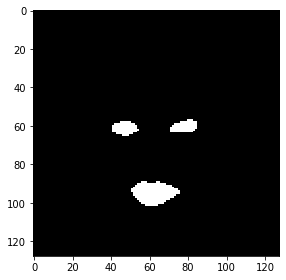

In [76]:
imshow(np.squeeze(Y_train[199]))

In [43]:
# Training our model with 10% data as validating data

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=100, callbacks = callbacks)

Epoch 1/100
51/51 [==============================] - 39s 103ms/step - loss: 0.2627 - accuracy: 0.8594 - val_loss: 0.0644 - val_accuracy: 0.9732
Epoch 2/100
51/51 [==============================] - 4s 73ms/step - loss: 0.0491 - accuracy: 0.9732 - val_loss: 0.0444 - val_accuracy: 0.9744
Epoch 3/100
51/51 [==============================] - 4s 73ms/step - loss: 0.0381 - accuracy: 0.9776 - val_loss: 0.0324 - val_accuracy: 0.9874
Epoch 4/100
51/51 [==============================] - 4s 73ms/step - loss: 0.0277 - accuracy: 0.9884 - val_loss: 0.0241 - val_accuracy: 0.9906
Epoch 5/100
51/51 [==============================] - 4s 73ms/step - loss: 0.0229 - accuracy: 0.9906 - val_loss: 0.0234 - val_accuracy: 0.9909
Epoch 6/100
51/51 [==============================] - 4s 74ms/step - loss: 0.0204 - accuracy: 0.9916 - val_loss: 0.0188 - val_accuracy: 0.9926
Epoch 7/100
51/51 [==============================] - 4s 73ms/step - loss: 0.0184 - accuracy: 0.9924 - val_loss: 0.0194 - val_accuracy: 0.9928
Epoc

In [ ]:
# Predicting values for testing data

preds_test = model.predict(X_test, verbose=1)

# Threshold predictions

preds_test_t = (preds_test > 0.5).astype(np.uint8)



/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


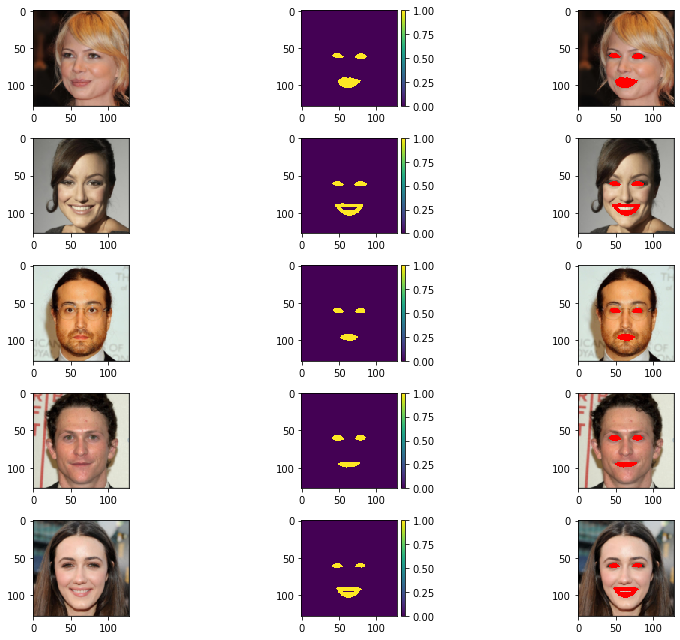

In [77]:
# Displaying the first 5 images from testing data, their predicted masks and the final masked images

fig=plt.figure(figsize=(15, 9))

for i in range(0,5):
  fig.add_subplot(5,3, 3*i+1)

  im1=deepcopy(X_test[i][:,:,:])
  imshow(im1)

  fig.add_subplot(5,3, 3*i+2)
  imshow(np.squeeze(preds_test_t[i])[:,:])

  fig.add_subplot(5,3, 3*i+3)
  im2=deepcopy(np.squeeze(preds_test_t[i])[:,:])

  for i in range(im2.shape[0]):
    for j in range(im2.shape[1]):

      if(im2[i,j]!=0):
        im1[i,j,:]=[255,0,0]
  imshow(im1)
plt.show()